In [1]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.5 MB/s eta 0:00:0000:0100:01


To be able to share your model with the community, there are a few more steps to follow.|

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your **write** token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
# prompt: to know version of jax

import jax
print(jax.__version__)


0.4.26



Then you need to install Git-LFS to upload your model checkpoints:

In [9]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 8
    eval_batch_size = 8 # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128'  # the model namy locally and on the HF Hub

 #   push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our image dataset.

In this case, the [Butterflies dataset](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) is hosted remotely, but you can load a local [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) as shown in the commets below.

In [5]:
from datasets import load_dataset

# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split="train")

# Feel free to try other datasets from https://hf.co/huggan/ too!
# Here's is a dataset of flower photos:
# config.dataset_name = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset_name, split="train")

# Or just load images from a local folder!
config.dataset_name = "imagefolder"
dataset = load_dataset(config.dataset_name, data_dir="/kaggle/input/temp256")

Resolving data files:   0%|          | 0/938 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

The dataset contains several extra `features` (columns), but the one that we're interested in is `image`:

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 938
    })
})

In [26]:
import numpy as np

image = dataset['train']['image'][0]
image_array = np.array(image)
print(image_array.shape)

(256, 256, 4)


In [6]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [7]:
def transform(examples):
    images = [preprocess(image.convert("L")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [45]:
dataset = dataset['train']

Let's see what they look like now

Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [18]:
import torch
dataset = dataset['train']
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [1]:
import jax
import jax.random as random

# Generate a PRNG key (KeyArray object in newer versions)
key = random.PRNGKey(42)

# Split the key if needed
subkeys = random.split(key, num=2)




## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):


In [8]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

2024-08-11 13:04:39.553493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 13:04:39.553630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 13:04:39.690011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import jax.random as jrand
key = jrand.PRNGKey(0)  # Initialize a PRNG key

In [10]:
i = dataset["train"][0]["images"]
i = i.unsqueeze(0)
print(i.shape)

Let's get a sample image from our dataset and pass it into our model. We just need to add a batch dimension:

In [12]:
#sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', i.shape)

Input shape: torch.Size([1, 1, 128, 128])


And let's check the output is a tensor of the same exact shape:

In [13]:
print('Output shape:', model(i, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 128, 128])


Great!

Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

## Defining the noise scheduler

Depending on the diffusion algorithm you want to use, the way images are noised is slightly different. That's why 🤗 Diffusers contains different scheduler classes which each define the algorithm-specific diffusion steps. Here we are going to use the `DDPMScheduler` which corresponds to the training denoising and training algorithm proposed in [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [9]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Let's see how this noise scheduler works: it takes a batch of images from the trainng set (here we will reuse the batch of one image `sample_image` form before), a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image):

In [ ]:
import torch
from PIL import Image

noise = torch.randn(i.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(i, noise, timesteps)



In [16]:
noisy_image.shape

torch.Size([1, 1, 128, 128])

In [ ]:
plt.imshow(noisy_image[0,0].detach().cpu().numpy(),"gray")

In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`, so the loss at this step would be:

In [21]:
import torch.nn.functional as F

# noise_pred = model(noisy_image, timesteps).sample
# loss = F.mse_loss(noise_pred, noise)

## Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [14]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk.

In [15]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

With this in end, we can group all together and write our training function. This just wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training.

In [16]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,

    )
    if accelerator.is_main_process:

      # config.output_dir is not None:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                # if config.push_to_hub:
                #     repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                # else:
                  pipeline.save_pretrained(config.output_dir)

## Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [22]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

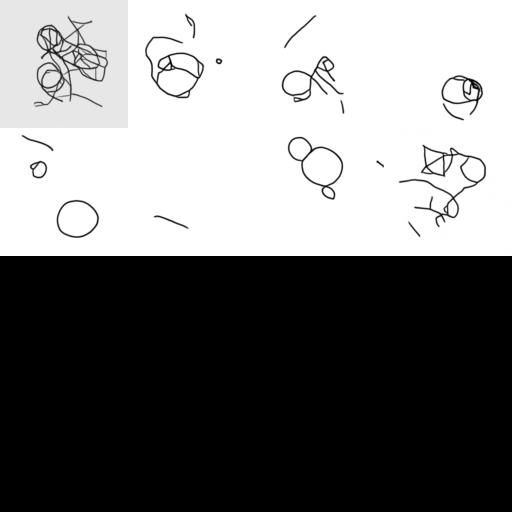

In [23]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [24]:
##  INFERENCE
accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,

    )


    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)


Let's have a look at the final image grid produced by the trained diffusion model:

In [30]:
def inference(pipeline, image, batch_size=1, seed=1234):
    # Set the generator seed for reproducibility
    generator = torch.manual_seed(seed)
    
    # Perform inference with batch size 1
    images = pipeline(
        batch_size=batch_size,
        generator=generator,
        input_image=image  # Pass the input image here
    ).images
    
    return images


In [25]:
import numpy as np
def read_csv ( csv_path ):
    np_path_XYs = np.genfromtxt ( csv_path , delimiter = ",")
    path_XYs = []
    for i in np.unique(np_path_XYs[: , 0]):
        npXYs = np_path_XYs[np_path_XYs[: , 0] == i ][: , 1:]
        XYs = []
        for j in np.unique(npXYs[: , 0]):
            XY = npXYs[npXYs[: , 0] == j ][: , 1:]
            XYs.append( XY )
        path_XYs.append ( XYs )
    return path_XYs

In [26]:
var = 1
var += 1
dir2_ = r'/kaggle/working/'

In [27]:
import numpy as np
import matplotlib . pyplot as plt
colours = ["black"]

def plot(ps, var):
   
    fig , ax = plt.subplots( tight_layout=True , figsize=(2.55, 2.55))
    
    for i , XYs in enumerate( ps ):
        
        c = colours[ i % len(colours)]
        
        for XY in XYs :
            
            ax.plot( XY[: , 0] , XY[: , 1] , c =c , linewidth =2)
            
    ax.set_aspect( 'equal')
    ax.axis('off')
    plt.savefig(dir2_ +'/'+ 'rand' + str(var))
    var +=1
    plt.show()

In [28]:
path = read_csv('/kaggle/input/genai-hackathon/frag0.csv')

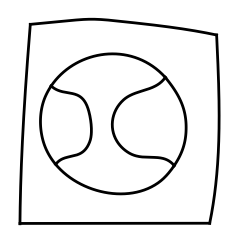

In [29]:
plot(path, var)
var +=1

In [33]:
from PIL import Image
x = Image.open(r"/kaggle/working/rand2.png").convert("L")       
#x = transform(x)

